# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# April 12, 2018

## Complex Objects and Distributions

# Literature / Useful References

### Books
- Jean Claude, Morphometry with R
- [Online](http://link.springer.com/book/10.1007%2F978-0-387-77789-4) through ETHZ
- [Buy it](http://www.amazon.com/Morphometrics-R-Use-Julien-Claude/dp/038777789X)
- John C. Russ, “The Image Processing Handbook”,(Boca Raton, CRC Press)
- Available [online](http://dx.doi.org/10.1201/9780203881095) within domain ethz.ch (or proxy.ethz.ch / public VPN) 
- J. Weickert, Visualization and Processing of Tensor Fields
 - [Online](http://books.google.ch/books?id=ScLxPORMob4C&lpg=PA220&ots=mYIeQbaVXP&dq=&pg=PA220#v=onepage&q&f=false)


### Papers / Sites
- Voronoi Tesselations
 - Ghosh, S. (1997). Tessellation-based computational methods for the characterization and analysis of heterogeneous microstructures. Composites Science and Technology, 57(9-10), 1187–1210
 - [Wolfram Explanation](http://mathworld.wolfram.com/VoronoiDiagram.html)

- Self-Avoiding / Nearest Neighbor
 - Schwarz, H., & Exner, H. E. (1983). The characterization of the arrangement of feature centroids in planes and volumes. Journal of Microscopy, 129(2), 155–169.
 - Kubitscheck, U. et al. (1996). Single nuclear pores visualized by confocal microscopy and image processing. Biophysical Journal, 70(5), 2067–77.

- Alignment / Distribution Tensor
 - Mader, K. et al (2013). A quantitative framework for the 3D characterization of the osteocyte lacunar system. Bone, 57(1), 142–154
 - Aubouy, M., et al. (2003). A texture tensor to quantify deformations. Granular Matter, 5, 67–70. Retrieved from http://arxiv.org/abs/cond-mat/0301018
- Two point correlation
 - Dinis, L., et. al. (2007). Analysis of 3D solids using the natural neighbour radial point interpolation method. Computer Methods in Applied Mechanics and Engineering, 196(13-16)
 


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Previously on QBI ...


- Image Enhancment 
 - Highlighting the contrast of interest in images
 - Minimizing Noise
- Understanding image histograms
- Automatic Methods
- Component Labeling
- Single Shape Analysis
- Complicated Shapes (Thickness Maps)

# Outline

- Motivation (Why and How?)
- Skeletons
 - Tortuosity
- Watershed Segmentation
 - Connected Objects

*** 

### Local Environment
 - Neighbors
 - Voronoi Tesselation
 - Distribution Tensor
 
***

### Global Enviroment
 - Alignment
 - Self-Avoidance
 - Two Point Correlation Function

# Metrics

We examine a number of different metrics in this lecture and additionally to classifying them as Local and Global we can define them as point and voxel-based operations. 

### Point Operations
- Nearest Neighbor
- Delaunay Triangulation
  - Distribution Tensor
- Point (Center of Volume)-based Voronoi Tesselation
- Alignment

### Voxel Operation
- Voronoi Tesselation
- Neighbor Counting
- 2-point (N-point) correlation function

# Learning Objectives

### Motivation (Why and How?)

- How can we extract topology of a structure?
- How do we identify seperate objects when they are connected?
- How can we compare shape of complex objects when they grow?

Text(0.5,1,'Distance Map\nBackground')

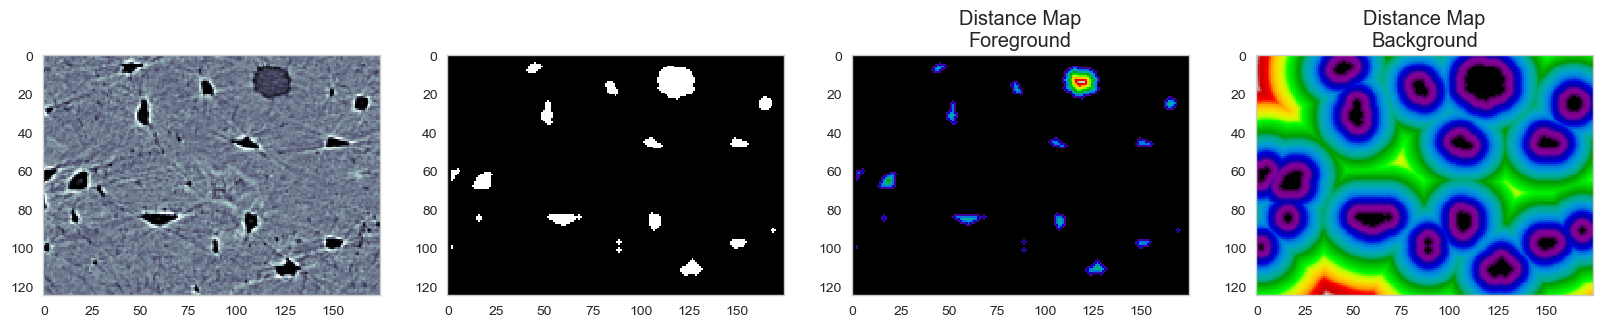

In [2]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_edt
bw_img = imread("ext-figures/bonegfiltslice.png")[::2, ::2]
from skimage.morphology import binary_opening, binary_closing, disk
thresh_img = binary_closing(binary_opening(bw_img < 90, disk(1)), disk(2))
fg_dmap = distance_transform_edt(thresh_img)
bg_dmap = distance_transform_edt(1-thresh_img)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
ax1.imshow(bw_img, cmap='bone')
ax2.imshow(thresh_img, cmap='bone')
ax3.set_title('Segmentation')
ax3.imshow(fg_dmap, cmap='nipy_spectral')
ax3.set_title('Distance Map\nForeground')
ax4.imshow(bg_dmap, cmap='nipy_spectral')
ax4.set_title('Distance Map\nBackground')

### Distribution Objectives
1. We want to know how many cells are alive
 - Maybe small cells are dead and larger cells are alive $\rightarrow$ examine the volume distribution
 - Maybe living cells are round and dead cells are really spiky and pointy $\rightarrow$ examine anisotropy

1. We want to know where the cells are alive or most densely packed
 - We can visually inspect the sample (maybe even color by volume)
 - We can examine the raw positions (x,y,z) but what does that really tell us?
 - We can make boxes and count the cells inside each one
 - How do we compare two regions in the same sample or even two samples?

# So what do we still need


1. A way for counting cells in a region and estimating density without creating arbitrary boxes
1. A way for finding out how many cells are _near_ a given cell, it's nearest neighbors
1. A way for quantifying how far apart cells are and then comparing different regions within a sample
1. A way for quantifying and comparing orientations



### What would be really great? 

A tool which could be adapted to answering a large variety of problems
- multiple types of structures
- multiple phases


Destructive Measurements
===
With most imaging techniques and sample types, the task of measurement itself impacts the sample.
- Even techniques like X-ray tomography which _claim_ to be non-destructive still impart significant to lethal doses of X-ray radition for high resolution imaging
- Electron microscopy, auto-tome-based methods, histology are all markedly more destructive and make longitudinal studies impossible
- Even when such measurements are possible
 - Registration can be a difficult task and introduce artifacts



### Why is this important?

- techniques which allow us to compare different samples of the same type.
- are sensitive to common transformations
 - Sample B after the treatment looks like Sample A stretched to be 2x larger
 - The volume fraction at the center is higher than the edges but organization remains the same


# Skeletonization / Networks


For some structures like cellular materials and trabecular bone, we want a more detailed analysis than just thickness. We want to know

- which structures are connected
- how they are connected
- express the network in a simple manner
 - quantify tortuosity
 - branching
 
We start with a simpler example from the EPFL Dataset: EPFL CVLab's Library of Tree-Reconstruction Examples (http://cvlab.epfl.ch/data/delin)

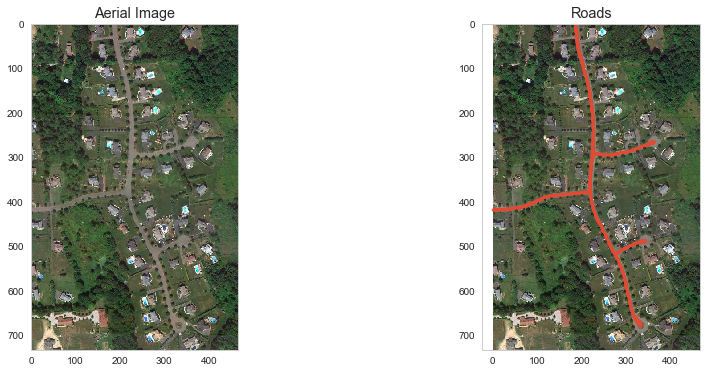

In [3]:
import matplotlib.pyplot as plt # for showing plots
from skimage.io import imread # for reading images
import numpy as np # for matrix operations and array support
import pandas as pd # for reading the swc files (tables of somesort)
def read_swc(in_path):
    swc_df = pd.read_csv(in_path, sep = ' ', comment='#', 
                         header = None)
    # a pure guess here
    swc_df.columns = ['id', 'junk1', 'x', 'y', 'junk2', 'width', 'next_idx']
    return swc_df[['x', 'y', 'width']]

im_data = imread('ext-figures/ny_7.tif')
mk_data = read_swc('ext-figures/ny_7.swc')

fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (15, 6))
ax1.imshow(im_data)
ax1.set_title('Aerial Image')
ax3.imshow(im_data,cmap = 'bone')
ax3.scatter(mk_data['x'], mk_data['y'], s = mk_data['width'], alpha = 0.5)
ax3.set_title('Roads');

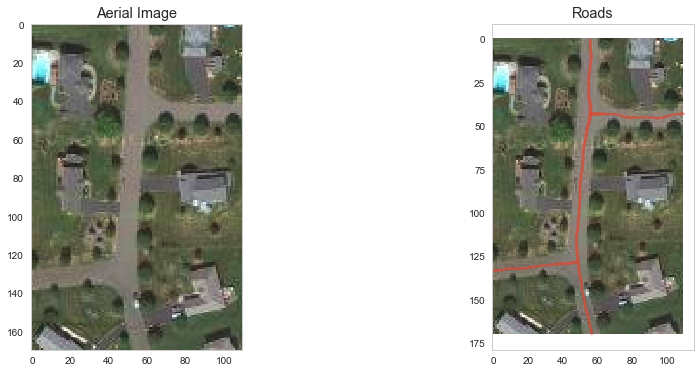

In [4]:
im_crop = im_data[250:420:1, 170:280:1]
mk_crop = mk_data.query('y>250').query('y<420').query('x>170').query('x<280').copy()
mk_crop.x = (mk_crop.x-170)/1
mk_crop.y = (mk_crop.y-250)/1
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (15, 6))
ax1.imshow(im_crop)
ax1.set_title('Aerial Image')
ax3.imshow(im_crop,cmap = 'bone')
ax3.scatter(mk_crop['x'], mk_crop['y'], s = mk_crop['width'], alpha = 0.25)
ax3.set_title('Roads');

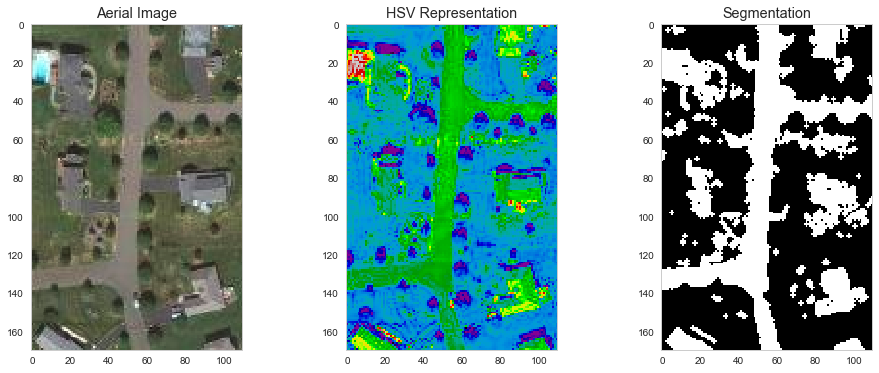

In [5]:
import seaborn as sns
from skimage.morphology import opening, closing, disk # for removing small objects
from skimage.color import rgb2hsv
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))
def thresh_image(in_img):
    v_img = rgb2hsv(in_img)[:,:,2]
    th_img = v_img>0.4
    op_img = opening(th_img, disk(1))
    return op_img

ax1.imshow(im_crop)
ax1.set_title('Aerial Image')
ax2.imshow(rgb2hsv(im_crop)[:,:,2],
                cmap='nipy_spectral')
ax2.set_title('HSV Representation')
seg_img = thresh_image(im_crop)
ax3.imshow(seg_img,cmap = 'bone')
ax3.set_title('Segmentation');

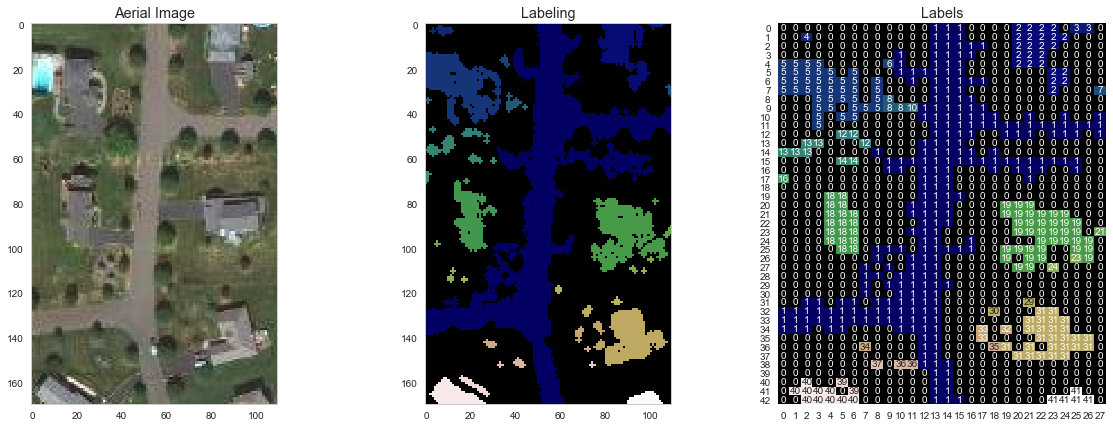

In [6]:
import seaborn as sns
from skimage.morphology import label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))

ax1.imshow(im_crop)
ax1.set_title('Aerial Image')
lab_img = label(seg_img)
ax2.imshow(lab_img, cmap = 'gist_earth')
ax2.set_title('Labeling');

sns.heatmap(lab_img[::4, ::4],
                annot=True,
                fmt="d",
                cmap='gist_earth',
                ax=ax3,
                cbar=False,
                vmin=0,
                vmax=lab_img.max(),
           annot_kws={"size": 10})
ax3.set_title('Labels');

# Skeletonization

The first step is to take the distance transform the structure 
$$I_d(x,y) = \textrm{dist}(I(x,y))$$
We can see in this image there are already local maxima that form a sort of backbone which closely maps to what we are interested in.


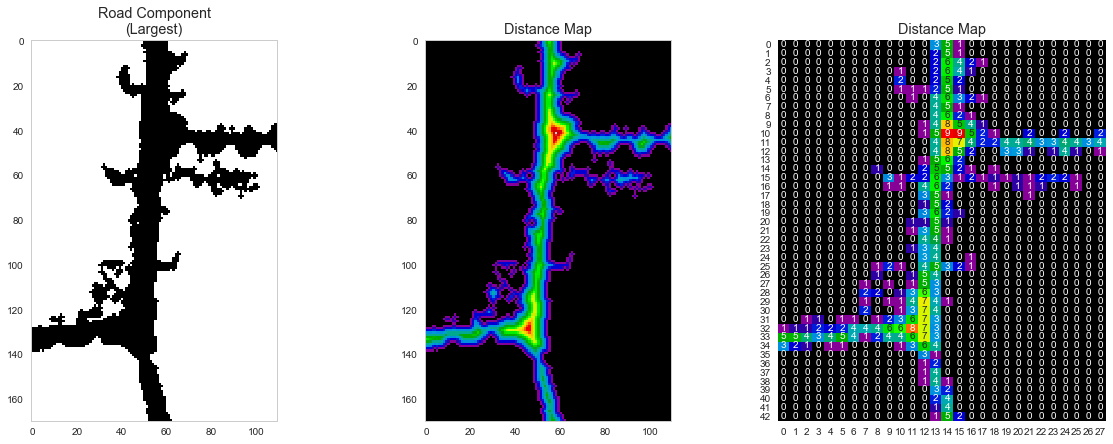

In [7]:
from scipy import ndimage
keep_lab_img = lab_img==1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
ax1.imshow(keep_lab_img)
ax1.set_title('Road Component\n(Largest)')
dist_map = ndimage.distance_transform_edt(keep_lab_img)
ax2.imshow(dist_map, cmap = 'nipy_spectral')
ax2.set_title('Distance Map');

sns.heatmap(dist_map[::4, ::4],
                annot=True,
                fmt="1.0f",
                cmap='nipy_spectral',
                ax=ax3,
                cbar=False,
                vmin=0,
                vmax=dist_map.max(),
           annot_kws={"size": 10})
ax3.set_title('Distance Map');

# Skeletonization: Ridges

By using the laplacian filter as an approximate for the derivative operator which finds the values which high local gradients.

$$ \nabla I_{d}(x,y) = (\frac{\delta^2}{\delta x^2}+\frac{\delta^2}{\delta y^2})I_d \approx \underbrace{\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{bmatrix}}_{\textrm{Laplacian Kernel}} \otimes I_d(x,y) $$

## Creating the skeleton


We can locate the local maxima of the structure by setting a minimum surface distance
$$I_d(x,y)>MIN_{DIST}$$
and combining it with a minimum slope value 
$$\nabla I_d(x,y) > MIN_{SLOPE}$$

***

### Thresholds
Harking back to our earlier lectures, this can be seen as a threshold on a feature vector representation of the entire dataset.
- We first make the dataset into a tuple

$$ \textrm{cImg}(x,y) = \langle \underbrace{I_d(x,y)}_1, \underbrace{\nabla I_d(x,y)}_2 \rangle $$

$$ \textrm{skelImage}(x,y) = $$
$$ \begin{cases}
1, & \textrm{cImg}_1(x,y)\geq MIN-DIST \\ 
 &  \& \textrm{ cImg}_2(x,y)\geq MIN-SLOPE \\
0, & \textrm{otherwise}
\end{cases}$$ 


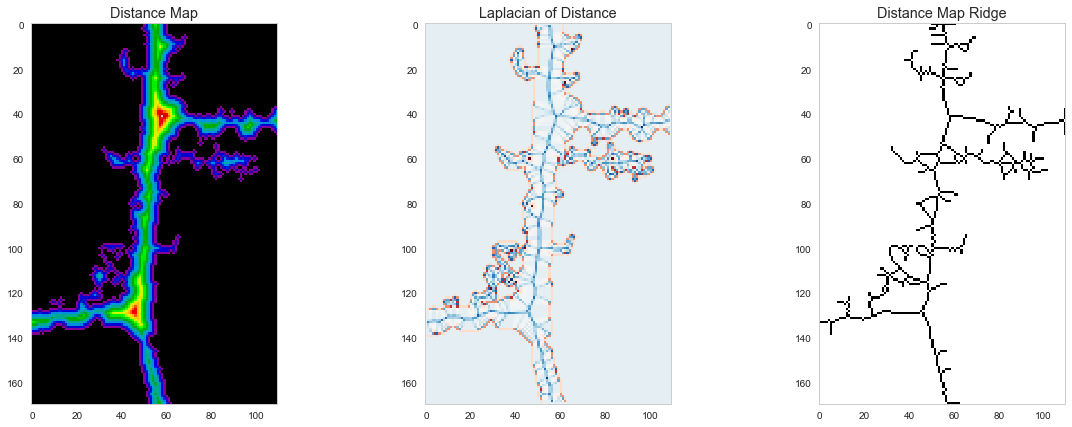

In [8]:
from skimage.morphology import medial_axis # for finding the medial axis and making skeletons
from skimage.morphology import skeletonize, skeletonize_3d # for just the skeleton code
from skimage.filters import laplace

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))

ax1.imshow(dist_map, cmap = 'nipy_spectral')
ax1.set_title('Distance Map');

ax2.imshow(laplace(dist_map), cmap = 'RdBu')
ax2.set_title('Laplacian of Distance')

# we use medial axis since it is cleaner
skel = medial_axis(keep_lab_img, return_distance=False)
ax3.imshow(skel)
ax3.set_title('Distance Map Ridge');

# Morphological thinning
From scikit-image documentation (http://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html)
```
Morphological thinning, implemented in the thin function, works on the same principle as skeletonize: remove pixels from the borders at each iteration until none can be removed without altering the connectivity. The different rules of removal can speed up skeletonization and result in different final skeletons.

The thin function also takes an optional max_iter keyword argument to limit the number of thinning iterations, and thus produce a relatively thicker skeleton.``` 

We can use this to thin the tiny junk elements first then erode, then perform the full skeletonization

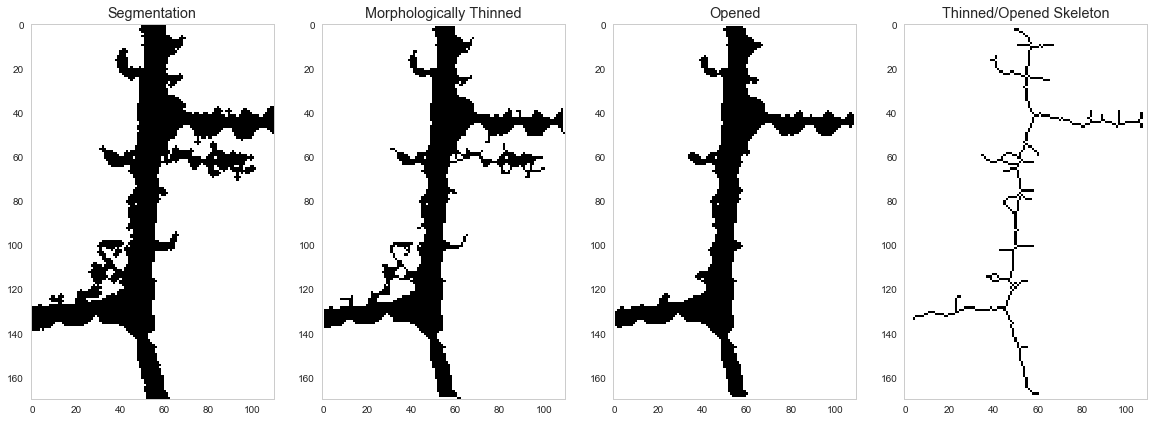

In [9]:
from skimage.morphology import thin, erosion
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 7))
ax1.imshow(keep_lab_img)
ax1.set_title('Segmentation')

thin_image = thin(keep_lab_img, max_iter=1)
ax2.imshow(thin_image)
ax2.set_title('Morphologically Thinned')

er_thin_image = opening(thin_image, disk(1))
er_thin_image = label(er_thin_image)==1
ax3.imshow(er_thin_image)
ax3.set_title('Opened')

opened_skeleton = medial_axis(er_thin_image, return_distance=False)
ax4.imshow(opened_skeleton)
ax4.set_title('Thinned/Opened Skeleton');

### Still overgrown
The skeleton is still problematic for us and so we require some additional improvements to get a perfect skeleton

# Skeleton: Junction Overview 


With the skeleton which is ideally one voxel thick, we can characterize the junctions in the system by looking at the neighborhood of each voxel.


Text(0.5,1,'Junction Count')

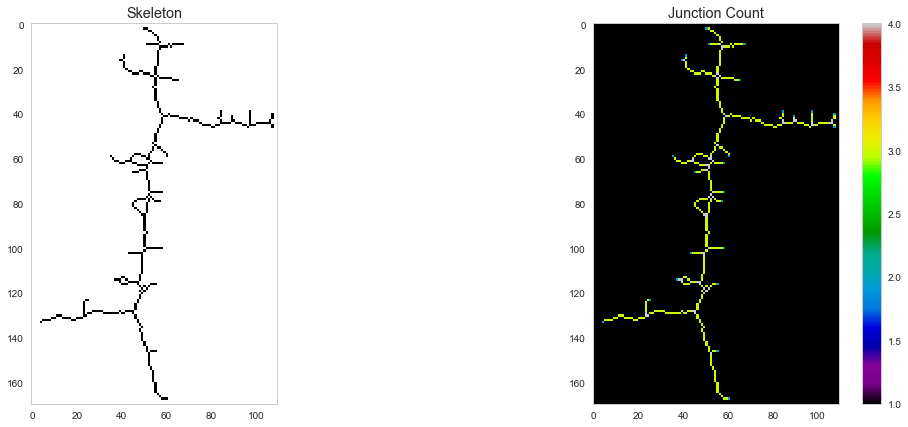

In [10]:
from scipy.ndimage import convolve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 7))
ax1.imshow(opened_skeleton)
ax1.set_title('Skeleton');
neighbor_conv = convolve(opened_skeleton.astype(int), np.ones((3,3)))
neighbor_conv[~opened_skeleton] = 0
j_img = ax2.imshow(neighbor_conv, 
           cmap = 'nipy_spectral',
           vmin = 1, vmax = 4, 
           interpolation = 'none')
plt.colorbar(j_img)
ax2.set_title('Junction Count');

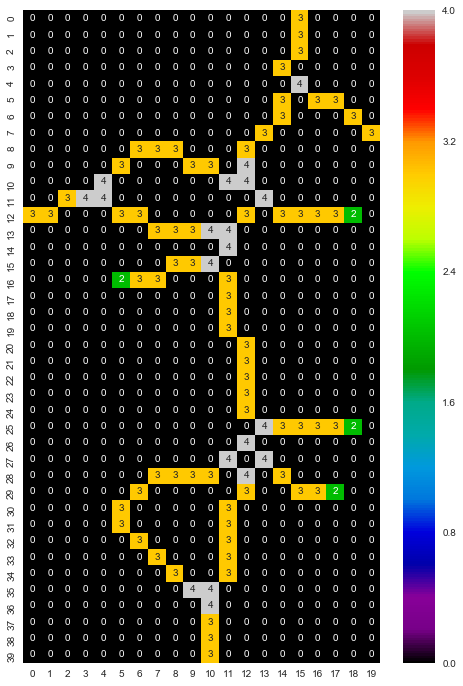

In [11]:
fig, ax1 = plt.subplots(1,1, figsize = (8, 12))
n_crop = neighbor_conv[50:90, 40:60]
sns.heatmap(n_crop,
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=ax1,
                cbar=True,
                vmin=0,
                vmax=n_crop.max(),
           annot_kws={"size": 10})

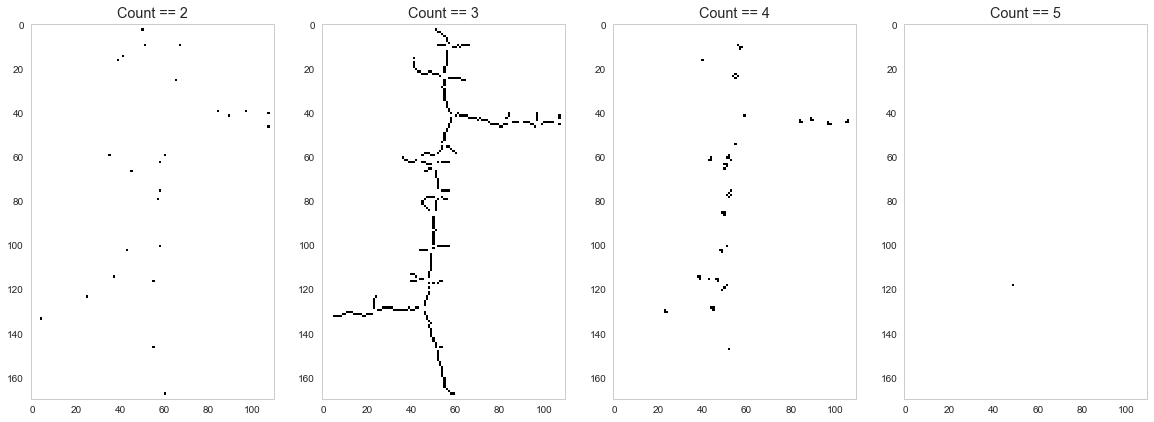

In [12]:
junc_types = np.unique(neighbor_conv[neighbor_conv>0])
fig, m_axs = plt.subplots(1,len(junc_types), figsize = (20, 7))
for i, c_ax in zip(junc_types, m_axs):
    c_ax.imshow(neighbor_conv==i, interpolation = 'none')
    c_ax.set_title('Count == {}'.format(i))

## Dedicated pruning algorithms
 - Ideally model-based
 - Minimum branch length (using component labeling on the Count==3)
 - Minimum branch width (using the distance map values)
 

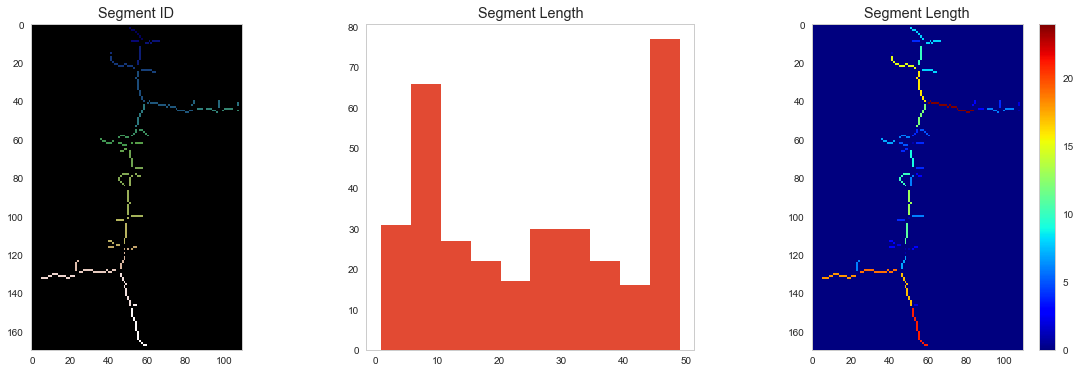

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))
lab_seg = label(neighbor_conv==3)
ax1.imshow(lab_seg, cmap = 'gist_earth')
ax1.set_title('Segment ID')
ax2.hist(lab_seg[lab_seg>0])
ax2.set_title('Segment Length')

label_length_img = np.zeros_like(lab_seg)
for i in np.unique(lab_seg[lab_seg>0]):
    label_length_img[lab_seg==i] = np.sum(lab_seg==i)
    
ll_ax = ax3.imshow(label_length_img, cmap = 'jet')
ax3.set_title('Segment Length')
plt.colorbar(ll_ax)

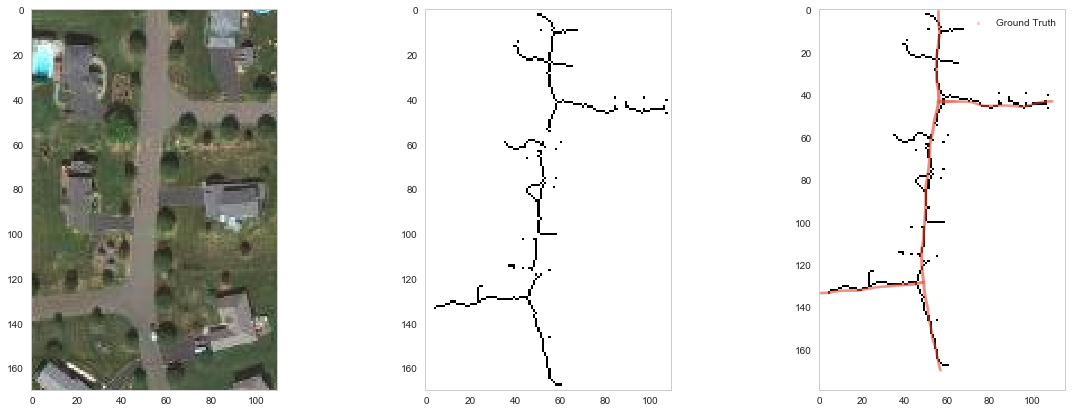

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
length_skeleton = (label_length_img>5)+(neighbor_conv==2)+(neighbor_conv>3)
ax1.imshow(im_crop)
ax2.imshow(length_skeleton)
ax3.imshow(length_skeleton)
ax3.scatter(mk_crop['x'], mk_crop['y'], s = mk_crop['width'], alpha = 0.25, label = 'Ground Truth')
ax3.legend()

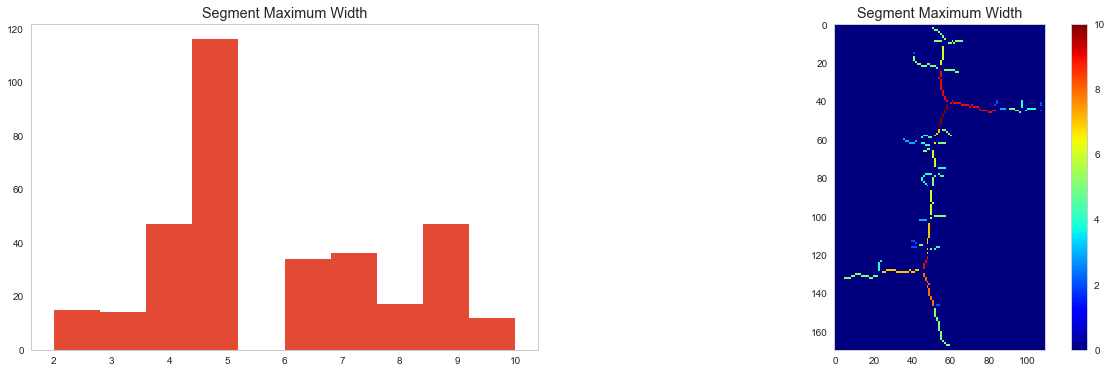

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))

label_width_img = np.zeros_like(lab_seg)
for i in np.unique(lab_seg[lab_seg>0]):
    label_width_img[lab_seg==i] = np.max(dist_map[lab_seg==i])

ax1.hist(label_width_img[label_width_img>0])
ax1.set_title('Segment Maximum Width')


    
ll_ax = ax2.imshow(label_width_img, cmap = 'jet')
ax2.set_title('Segment Maximum Width')
plt.colorbar(ll_ax)

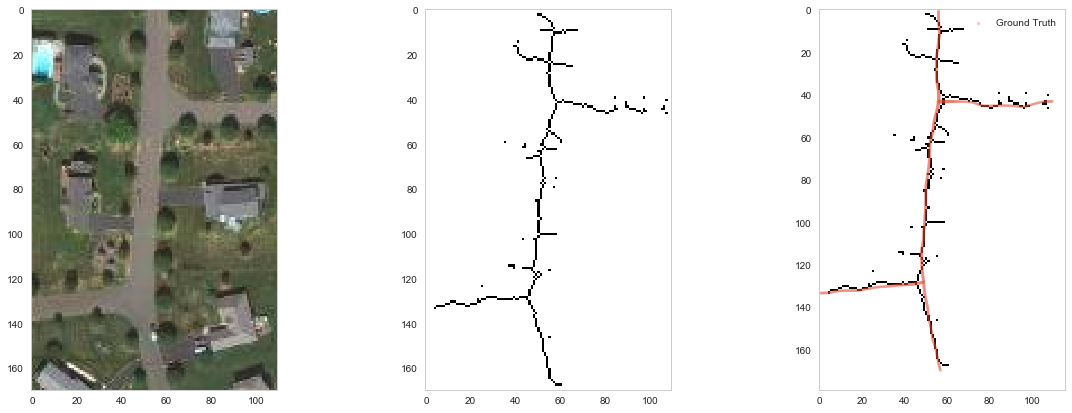

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
width_skeleton = (label_width_img>4.5)+(neighbor_conv==2)+(neighbor_conv>3)
ax1.imshow(im_crop)
ax2.imshow(width_skeleton)
ax3.imshow(width_skeleton)
ax3.scatter(mk_crop['x'], mk_crop['y'], s = mk_crop['width'], alpha = 0.25, label = 'Ground Truth')
ax3.legend()